In [4]:
import os 
from glob import glob
from functools import reduce 
import math
import numpy as np
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import xarray as xr
import pandas as pd
from SALib.analyze import delta

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["font.size"] = 11
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.50

from matplotlib.colors import LinearSegmentedColormap, ListedColormap

cm_data = np.loadtxt("./utils/colormaps/batlow.txt")[::-1]
sc_cmap = LinearSegmentedColormap.from_list("cmap", cm_data, N=10)

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from utils.global_paths import project_data_path, project_code_path, loca_path

In [5]:
# Info 
subset_name = 'eCONUS'
obs_names = ['SMAP', 'VIC', 'NOAH', 'MOSAIC']

# Metrics
soil_metrics = ['mean-anom', '5dmin-anom', '5dmax-anom',
                'mean-change', '5dmin-change', '5dmax-change',
                'mean', '5dmin', '5dmax']

# Soil labels for plots
soil_labels = {"mean-anom": "Annual Average \nSoil Moisture Anomaly", 
               "5dmin-anom": "Soil Moisture Anomaly \nDuring Driest 5 Days",
               "5dmax-anom": "Soil Moisture Anomaly \nDuring Wettest 5 Days",
               "mean-change": "Annual Average Soil Moisture \n(Change from Historical)", 
               "5dmin-change": "Soil Moisture During Driest 5 Days \n(Change from Historical)",
               "5dmax-change": "Soil Moisture During Wettest 5 Days \n(Change from Historical)",
               "mean": "Annual Average \nSoil Moisture", 
               "5dmin": "Soil Moisture \nDuring Driest 5 Days",
               "5dmax": "Soil Moisture \nDuring Wettest 5 Days"}

# Index labels for SA plot
index_labels = {'ssp':'SSP',
                'model':'Climate \nmodel',
                'time':'Year',
                'obs_name':'Obs.\nproduct',
                'loss_metric':'Loss\nFunction',
                'soil_id':'Soil Parameters'}

# SA colors
climate_color = 'cornflowerblue'
soil_color = 'orange'

# Plot styles
obs_colors = {'SMAP':"#e7298a", 'VIC':"#d95f02", 'NOAH':"#7570b3", 'MOSAIC':"#1b9e77"}
ls_ssp = {'ssp245':'--', 'ssp370':'-'}

# Time slices to analyze
time_slices = [[2030, 2039], [2050,2059], [2080,2089]]

# SSPs
ssps = ['ssp245', 'ssp370']

In [3]:
############
### Dask ###
############
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    # account="pches",
    account="open",
    cores=1,
    memory="20GiB",
    walltime="00:20:00"
)
cluster.scale(jobs=10)  # ask for jobs

from dask.distributed import Client
client = Client(cluster)
client

<Client: 'tcp://10.6.0.163:43169' processes=0 threads=0, memory=0 B>

### Preliminaries

In [6]:
# Models 
models = os.listdir(f"{loca_path}/")
models.remove('training_data')
models.remove('scripts')

loca_all = {}

# Loop through models
for model in models:
    loca_all[model] = {}
    # Loop through members
    members = os.listdir(f"{loca_path}/{model}/0p0625deg/")
    for member in members:
        # Append SSPs
        ssps = os.listdir(f"{loca_path}/{model}/0p0625deg/{member}/")
        loca_all[model][member] = ssps

# Matches website (https://loca.ucsd.edu/loca-version-2-for-north-america-ca-jan-2023/) as of Jan 2023
print(f"# models: {len(models)}")
print(f"# model/expts: {np.sum([len(np.unique([item for row in [loca_all[model][member] for member in loca_all[model].keys()] for item in row])) for model in models])}")
print(f"# model/expts/ens: {np.sum([len(loca_all[model][ssp]) for model in models for ssp in loca_all[model]])}")
print(f"# model/expts/ens (not including historical): {np.sum([len([ssp for ssp in loca_all[model][member] if ssp != 'historical']) for model in models for member in loca_all[model]])}")

# models: 27
# model/expts: 99
# model/expts/ens: 329
# model/expts/ens (not including historical): 221


In [7]:
# Read all soil moisture metrics
def read_all(subset_name, soil_metric, ssps):
    # For all
    ds_all = []

    # Loop through models
    for model in models:
        # Take first member only
        for member in list(loca_all[model].keys())[:1]:
            # Loop through SSPs
            for ssp in loca_all[model][member]:
                if ssp in ssps:
                    projection_id = f"{model}_{member}_{ssp}"
                    ds_proj = []
                    # Loop through obs
                    for obs_name in obs_names:
                        # Concat along loss metrics
                        ds = xr.open_mfdataset(f"{project_data_path}/projections/{subset_name}/metrics/{soil_metric}/{projection_id}_{obs_name}_*.nc",
                                                combine="nested", concat_dim = "loss_metric")
                        # Append
                        ds_proj.append(ds)
                    # Concat along obs
                    ds_proj = xr.concat(ds_proj, dim="obs_name")
                    ds_all.append(ds_proj)
                    
    # Concat along climate
    ds_all = xr.concat(ds_all, dim="projection_id")

    # Fix time dim
    ds_all['time'] = ds_all['time'].dt.year

    return ds_all

In [8]:
# Calculate delta indexes using SAlib
def get_delta_single(df_loc, soil_metric, sa_factors):
    # Shuffle otherwise incorrect
    df = df_loc.sample(frac = 1)
    
    # Problem def
    n_factors = len(sa_factors)
    
    problem = {
        'num_vars': n_factors,
        'names': sa_factors,
    }

    # Do it
    X = df[sa_factors].to_numpy()
    Y = df[soil_metric].to_numpy()
    Si = delta.analyze(problem, X, Y).to_df()
    
    return Si

In [9]:
# Plotting function
def plot_sa_single(Si, names, climate_color, soil_color, index_labels, legend, ylabel, ax):
    # Plot style
    index_colors = {'ssp':climate_color,
                    'model':climate_color,
                    'time':climate_color,
                    'obs_name':soil_color,
                    'loss_metric':soil_color,
                    'soil_id':soil_color}

    # Make plot
    Si.plot.bar(ax=ax, y ='delta', yerr='delta_conf', 
                color=[index_colors[name] for name in names])

    if ylabel:
        ax.set_ylabel('Delta Sensitivity Index')
    else:
        ax.set_ylabel('')
        
    ax.set_xticks(ticks = np.arange(len(names)),
                  labels=[index_labels[name] for name in names],
                  rotation=0)

    custom_lines = [Line2D([0], [0], color=climate_color, lw=4),
                    Line2D([0], [0], color=soil_color, lw=4)]
    if legend: 
        ax.legend(custom_lines, ['Climate', 'Soil'], handlelength=1)
    else:
        ax.legend().remove()

    ax.grid(alpha=0.5)
    ax.set_axisbelow(True)

# Trends

## Functions

In [8]:
# Read all for single location
def read_loc_all(soil_metric, lat, lon):
    # Load and select gridpoint
    ds = read_all(subset_name, soil_metric, ssps)
    ds_loc = ds.sel(lat=lat, lon=lon, method='nearest').load()
    return ds_loc.to_dataframe().reset_index()

In [9]:
# Function to get trends
def get_trends(df, soil_metric):
    # Get linear trends
    def model(df):
        y = df[[soil_metric]].to_numpy()
        X = df['time'].to_numpy()
        return np.polyfit(X, y, 1)[0][0]

    # Get trends
    trends = 10 * df.groupby(['soil_id', 'projection_id']).apply(model) # change per decade 

    # Plot
    df_trends = pd.DataFrame({'trend':trends}).reset_index()
    df_trends['obs_name'] = df_trends['soil_id'].apply(lambda x: x.split('_')[0])
    df_trends['loss_metric'] = df_trends['soil_id'].apply(lambda x: x.split('_')[1])
    df_trends['ssp'] = df_trends['projection_id'].apply(lambda x: x.split('_')[-1])
    df_trends['model'] = df_trends['projection_id'].apply(lambda x: x.split('_')[0])
    return df_trends

In [10]:
# Plot trends probability density function
def plot_trend_pdf(df_trends, ax):
    # Plot
    for obs_name in obs_names:
        for ssp in ssps:
            df_tmp = df_trends[(df_trends['ssp'] == ssp) & (df_trends['obs_name'] == obs_name)]['trend']
            df_tmp.plot.kde(color=obs_colors[obs_name], ls=ls_ssp[ssp], ax=ax)

    ax.set_xlim([df_trends['trend'].min(),df_trends['trend'].max()])
    ax.grid(alpha=0.5)
    ax.set_yticklabels('')
    ax.set_xlabel('Trend [mm/decade]')
    ax.set_ylabel('')

In [11]:
# Stylized boxplot
def custom_bxp(data, x, color, ls, ax):
    data_mean = data.mean()
    data_q975 = np.quantile(data, 0.975)
    data_q025 = np.quantile(data, 0.025)
    # data_max = data.max()
    # data_min = data.min()

    # Plot
    ax.scatter([x], [data_mean], color=color, s=10)
    ax.plot([x,x], [data_q025, data_q975], lw=2, color=color, ls=ls)
    # ax.plot([x,x], [data_min, data_max], lw=1.5, color=color, ls=ls)

In [12]:
# Plot time series of stylized boxplot
def timeseries_bxp(df, soil_metric, ax):
    decades = np.arange(2035, 2099, 20)
    for year in decades:
        spacer = 0 # x axis spacer
        for obs_name in obs_names:
            spacer+=1
            for ssp in ssps:
                year_margin = 1 # how many years to include either side of central year
                data = df[(df['obs_name'] == obs_name) & (df['ssp'] == ssp) & (df['time'] >= (year-year_margin)) & (df['time'] <= (year+year_margin))][soil_metric]
                custom_bxp(data=data, x=year+spacer-6, color=obs_colors[obs_name], ls=ls_ssp[ssp], ax=ax)
                spacer+=1

    ax.grid(alpha=0.5)
    ax.set_ylabel('Soil Moisture [mm]')
    ax.set_xticks(decades, [f"{decade}" for decade in decades-5])

## Plot

### Single gridpoint

In [14]:
# lat, lon = 40.61752192312278, -88.68366477345201 # McLean county
# lat, lon = 35.61832908163286, -83.66546369858804 # Smoky mountains
lat, lon = 29.22124625856724, -103.22586554830667 # Big Bend

In [15]:
%%time
sa_factors = ['ssp', 'model', 'obs_name', 'loss_metric']

# Mean
soil_metric = 'mean'
df_mean = read_loc_all(soil_metric, lat, lon)
df_mean_trends = get_trends(df_mean, soil_metric)
df_mean_trends_Si = get_delta_single(df_mean_trends, 'trend', sa_factors)

# 5dmin
soil_metric = '5dmin'
df_5dmin = read_loc_all(soil_metric, lat, lon)
df_5dmin_trends = get_trends(df_5dmin, soil_metric)
df_5dmin_trends_Si = get_delta_single(df_5dmin_trends, 'trend', sa_factors)

# 5dmax
soil_metric = '5dmax'
df_5dmax = read_loc_all(soil_metric, lat, lon)
df_5dmax_trends = get_trends(df_5dmax, soil_metric)
df_5dmax_trends_Si = get_delta_single(df_5dmax_trends, 'trend', sa_factors)

CPU times: user 2min 2s, sys: 22 s, total: 2min 24s
Wall time: 5min 46s


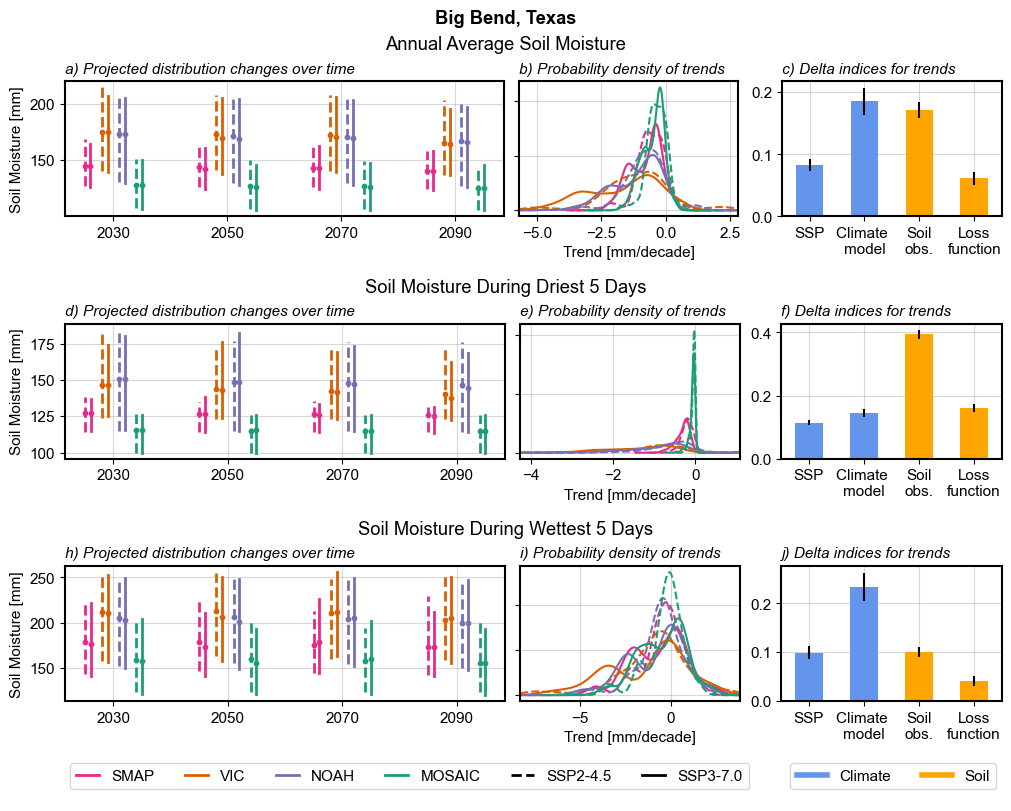

In [16]:
fig = plt.figure(layout='constrained', figsize=(10, 8))
subfigs = fig.subfigures(4, 1, hspace=0.05, height_ratios = [5,5,5,1])

# fig.suptitle('McLean County, Illinois', fontweight='bold')
fig.suptitle('Big Bend, Texas', fontweight='bold')

climate_color = 'cornflowerblue'
soil_color = 'orange'

index_labels = {'ssp':'SSP',
                'model':'Climate \nmodel',
                'obs_name':'Soil\nobs.',
                'loss_metric':'Loss\nfunction'}

############ Mean
axs = subfigs[0].subplots(1, 3, width_ratios=[2,1,1], gridspec_kw=dict(wspace=0.03))
soil_metric = 'mean'
subfigs[0].suptitle(soil_labels[soil_metric].replace('\n',''))

# TS
timeseries_bxp(df_mean, soil_metric, axs[0])
axs[0].set_title('a) Projected distribution changes over time', style='italic', loc='left', fontsize=11)

# Trends
plot_trend_pdf(df_mean_trends, axs[1])
axs[1].set_title('b) Probability density of trends', style='italic', loc='left', fontsize=11)

# SA
plot_sa_single(df_mean_trends_Si, sa_factors, climate_color, soil_color, index_labels, False, False, axs[2])
axs[2].set_title('c) Delta indices for trends', style='italic', loc='left', fontsize=11)

############ 5dmin
axs = subfigs[1].subplots(1, 3, width_ratios=[2,1,1], gridspec_kw=dict(wspace=0.03))
soil_metric = '5dmin'
subfigs[1].suptitle(soil_labels[soil_metric].replace('\n',''))
# TS
timeseries_bxp(df_5dmin, soil_metric, axs[0])
axs[0].set_title('d) Projected distribution changes over time', style='italic', loc='left', fontsize=11)

# Trends
plot_trend_pdf(df_5dmin_trends, axs[1])
axs[1].set_title('e) Probability density of trends', style='italic', loc='left', fontsize=11)

# SA
plot_sa_single(df_5dmin_trends_Si, sa_factors, climate_color, soil_color, index_labels, False, False, axs[2])
axs[2].set_title('f) Delta indices for trends', style='italic', loc='left', fontsize=11)

############ 5dmax
axs = subfigs[2].subplots(1, 3, width_ratios=[2,1,1], gridspec_kw=dict(wspace=0.03))
soil_metric = '5dmax'
subfigs[2].suptitle(soil_labels[soil_metric].replace('\n',''))
# TS
timeseries_bxp(df_5dmax, soil_metric, axs[0])
axs[0].set_title('h) Projected distribution changes over time', style='italic', loc='left', fontsize=11)

# Trends
plot_trend_pdf(df_5dmax_trends, axs[1])
axs[1].set_title('i) Probability density of trends', style='italic', loc='left', fontsize=11)

# SA
plot_sa_single(df_5dmax_trends_Si, sa_factors, climate_color, soil_color, index_labels, False, False, axs[2])
axs[2].set_title('j) Delta indices for trends', style='italic', loc='left', fontsize=11)

# Add legend
axs = subfigs[3].subplots(1,2, width_ratios = [3,1])

# Left
ax = axs[0]
lw=2
custom_lines = [Line2D([0], [0], color=obs_colors['SMAP'], lw=lw),
                Line2D([0], [0], color=obs_colors['VIC'], lw=lw),
                Line2D([0], [0], color=obs_colors['NOAH'], lw=lw),
                Line2D([0], [0], color=obs_colors['MOSAIC'], lw=lw),
                Line2D([0], [0], color='black', lw=lw, ls='--'),
                Line2D([0], [0], color='black', lw=lw, ls='-')]
ax.legend(custom_lines, ['SMAP', 'VIC', 'NOAH', 'MOSAIC', 'SSP2-4.5', 'SSP3-7.0'],
                 ncols=6, fontsize=11, loc=(0.09,0.5), handlelength=1.5)
ax.axis('off')

# Right
ax = axs[1]
custom_lines = [Line2D([0], [0], color=climate_color, lw=4),
                    Line2D([0], [0], color=soil_color, lw=4)] 
ax.legend(custom_lines, ['Climate', 'Soil'], ncols=2, loc=(0.07,0.5))
ax.axis('off')

plt.savefig('../figs/si/trends_bigbend_sa.pdf', bbox_inches='tight')

### Map

In [13]:
# Read trends
ds_trend_mean = xr.open_dataset(f'{project_data_path}/projections/{subset_name}/metrics/mean_trend.nc')
ds_trend_5dmin = xr.open_dataset(f'{project_data_path}/projections/{subset_name}/metrics/5dmin_trend.nc')
ds_trend_5dmax = xr.open_dataset(f'{project_data_path}/projections/{subset_name}/metrics/5dmax_trend.nc')

# Read trend SA
sa_type = 'soil_grouped'
ds_trend_mean_sa = xr.open_dataset(f'{project_data_path}/projections/{subset_name}/sa_results/mean_trends_delta-sa_{sa_type}.nc')
ds_trend_5dmin_sa = xr.open_dataset(f'{project_data_path}/projections/{subset_name}/sa_results/5dmin_trends_delta-sa_{sa_type}.nc')
ds_trend_5dmax_sa = xr.open_dataset(f'{project_data_path}/projections/{subset_name}/sa_results/5dmax_trends_delta-sa_{sa_type}.nc')

/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-09-jax/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-09-jax/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-09-jax/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-09-jax/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-09-jax/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/storage/h

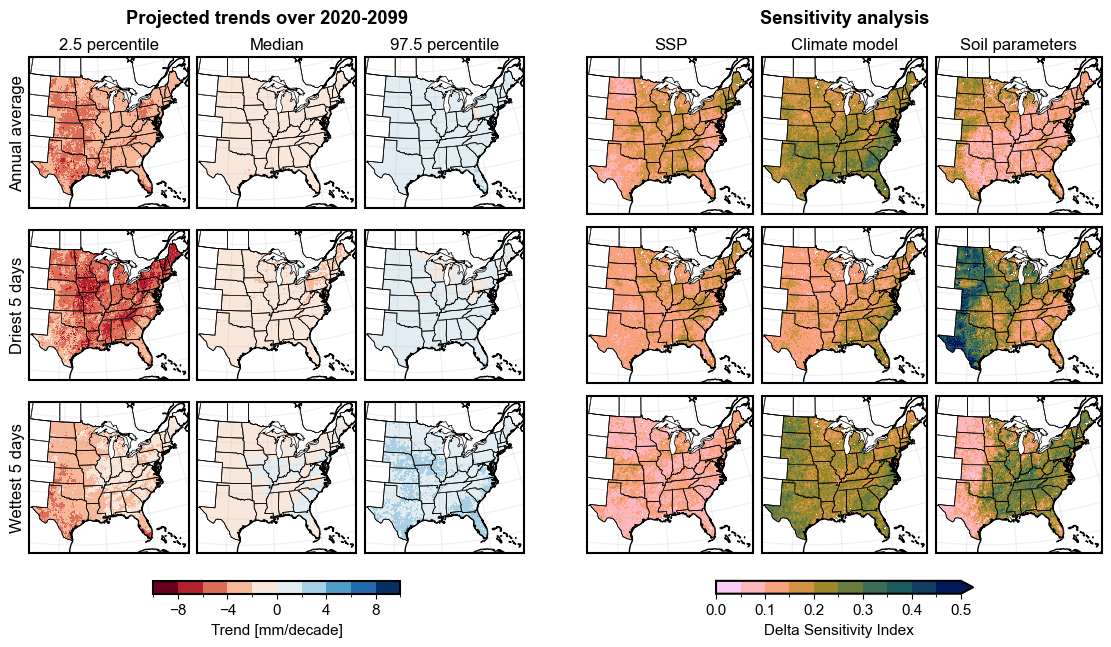

In [14]:
##### Plot
fig = plt.figure(layout='constrained', figsize=(11, 6))
subfigs = fig.subfigures(1, 2, wspace=0.1)

# Trends
subfigs[0].suptitle('Projected trends over 2020-2099', fontweight='bold', y=1.05)
axs = subfigs[0].subplots(3, 3, sharex=True, sharey=True,
                   gridspec_kw=dict(wspace=0.01, hspace=0.01),
                   subplot_kw=dict(projection=ccrs.LambertConformal()))
vmin, vmax = -1, 1
cmap = 'RdBu'

for idm, ds in enumerate([ds_trend_mean, ds_trend_5dmin, ds_trend_5dmax]):
    for idq, q in enumerate([0.025, 0.5, 0.975]):
        ax = axs[idm, idq]
    
        # Get quantile
        ds_q = ds.sel(coef='trend')['result'].quantile(q, dim=['projection_id', 'obs_name', 'loss_metric']) * 10 # trends per decade
    
        # Plot
        p = ds_q.plot(ax = ax, levels = 11,
                      add_colorbar = False,
                      vmin = vmin * 10, # mm/decade
                      vmax = vmax * 10, # mm/decade
                      cmap = cmap,
                      transform = ccrs.PlateCarree())
        
        # Tidy
        ax.coastlines()
        gl = ax.gridlines(draw_labels=False, x_inline=False, rotate_labels=False, alpha=0.2)
        ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
        ax.set_extent([-106, -73, 23, 51], ccrs.Geodetic())
        if idm == 0:
            if idq == 0:
                ax.set_title('2.5 percentile', fontsize=12)
            elif idq == 1:
                ax.set_title('Median', fontsize=12)
            elif idq ==2:
                ax.set_title('97.5 percentile', fontsize=12)
        else:
            ax.set_title('')

# Metrics
for idl, soil_label in enumerate(['Annual average', 
                                  'Driest 5 days',
                                  'Wettest 5 days']):
    axs[idl,0].text(-0.075, 0.5, soil_label, horizontalalignment='center', fontsize=12,
                    rotation=90, verticalalignment='center', transform=axs[idl,0].transAxes)
    
# Cbar
subfigs[0].colorbar(p,
             orientation="horizontal",
             label="Trend [mm/decade]",
             ax=axs, pad=0.05, shrink=0.5)

## SA
sa_factors = {'ssp':'SSP', 'model':'Climate model', 'soil_id':'Soil parameters'}

vmax = 0.5
cmap = sc_cmap

subfigs[1].suptitle('Sensitivity analysis', fontweight = 'bold', y=1.05)

axs = subfigs[1].subplots(3, 3, sharex=True, sharey=True,
                   gridspec_kw=dict(wspace=0.01, hspace=0.01),
                   subplot_kw=dict(projection=ccrs.LambertConformal()))

# Loop through metrics, factors
for idm, ds in enumerate([ds_trend_mean_sa, ds_trend_5dmin_sa, ds_trend_5dmax_sa]):
    for idf, factor in enumerate(sa_factors):
        # Plot
        ax=axs[idm,idf]
        p = ds[factor].plot(ax=ax, vmin=0., vmax=vmax, 
                                 levels=11, cmap=cmap,
                                 add_colorbar=False, transform=ccrs.PlateCarree())
        # Tidy
        ax.coastlines()
        gl = ax.gridlines(draw_labels=False, x_inline=False, rotate_labels=False, alpha=0.2)
        ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
        ax.set_extent([-106, -73, 23, 51], ccrs.Geodetic())
        if idm == 0:
            ax.set_title(sa_factors[factor], fontsize=12)

# Cbar
subfigs[1].colorbar(p,
                    orientation="horizontal",
                    label="Delta Sensitivity Index",
                    ax=axs, pad=0.05, shrink=0.5)

plt.savefig('../figs/main/fig8_trends_map_sa.png', dpi=600, bbox_inches='tight')

# Anomaly or change

## Maps

In [10]:
def make_sa_map_plot(metric_type, year, soil_sa, save_folder):
    """
    Plots a map of Delta SA results for specified time period, metric, and SA grouping. 
    """

    # Plot info
    metric_type_explainer = "2016-2022" if metric_type == "change" else "10-year running mean"

    if soil_sa == "soil_grouped":
        sa_factor_names = {'ssp':'SSP', 
                           'model':'Climate model', 
                           'time':'Year', 
                           'soil_id':'Soil parameters'}
        ncol = 4
        ysup = 0.93
    else:
        sa_factor_names = {'ssp':'SSP', 
                           'model':'Climate model', 
                           'time':'Year', 
                           'obs_name':'Obs. product', 
                           'loss_metric':'Error metric'}
        ncol = 5
        ysup=0.91

    sa_factors = sa_factor_names.keys()

    # Save folder
    savepath = f'../figs/{save_folder}/metrics_{metric_type}_sa_{year}_{soil_sa}.png'

    # Title
    title = f"{year} {metric_type} (relative to {metric_type_explainer})"

    # Which metrics to plot
    soil_metrics_plot = [f"{metric}-{metric_type}" for metric in ["mean", "5dmin", "5dmax"]]
    
    # Read all
    ds_all = [xr.open_dataset(f'{project_data_path}/projections/eCONUS/sa_results/{soil_metric}_{year}_delta-sa_{soil_sa}.nc') 
              for soil_metric in soil_metrics_plot]
    
    # Plot
    vmax = 0.5
    cmap = sc_cmap
    
    fig, axs = plt.subplots(3, ncol, figsize=(9, 8), sharex=True, sharey=True,
                       gridspec_kw=dict(wspace=0.1, hspace=0.01),
                       subplot_kw=dict(projection=ccrs.LambertConformal()))
    
    for idx, soil_metric in enumerate(soil_metrics_plot):
        for idf, factor in enumerate(sa_factors):
            # Plot
            ax=axs[idx,idf]
            p = ds_all[idx][factor].plot(ax=ax, vmin=0., vmax=vmax, 
                                         levels=11, cmap=cmap,
                                         add_colorbar=False, transform=ccrs.PlateCarree())
            # Tidy
            ax.coastlines()
            gl = ax.gridlines(draw_labels=False, x_inline=False, rotate_labels=False, alpha=0.2)
            ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
            ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
            ax.set_extent([-106, -73, 23, 51], ccrs.Geodetic())
            if idx == 0:
                ax.set_title(sa_factor_names[factor], fontsize=12)
    
    # for ax in axs[-1,:]:
    #     gl = ax.gridlines(draw_labels=True, x_inline=False, rotate_labels=False, alpha=0.3)
    #     gl.top_labels = False
    #     gl.right_labels = False
    #     gl.left_labels = False
    
    # for ax in axs[:,-1]:
    #     gl = ax.gridlines(draw_labels=True, x_inline=False, rotate_labels=False, alpha=0.3)
    #     gl.top_labels = False
    #     gl.bottom_labels = False
    #     gl.left_labels = False
    
    # Metrics
    for idl, soil_label in enumerate(['Annual average', 'Driest 5 days', 'Wettest 5 days']):
        axs[idl,0].text(-0.075, 0.5, soil_label, horizontalalignment='center', fontsize=12,
                        rotation=90, verticalalignment='center', transform=axs[idl,0].transAxes)
    
    # Cbar
    fig.colorbar(p,
                 orientation="horizontal",
                 label="Delta Sensitivity Index",
                 ax=axs, pad=0.05, shrink=0.5)

    # Store
    fig.suptitle(title, fontweight='bold', y=ysup)
    plt.savefig(savepath, dpi=600, bbox_inches='tight')

change 2080-2089 all
change 2080-2089 soil_grouped


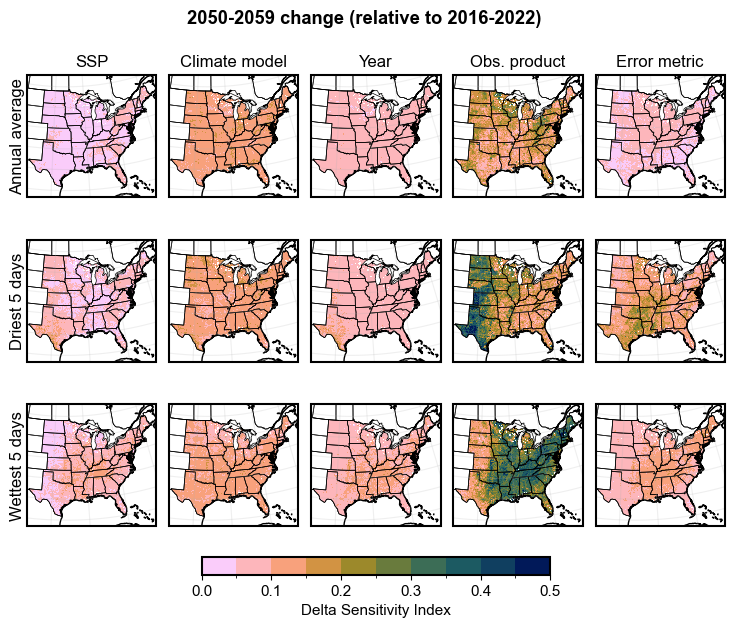

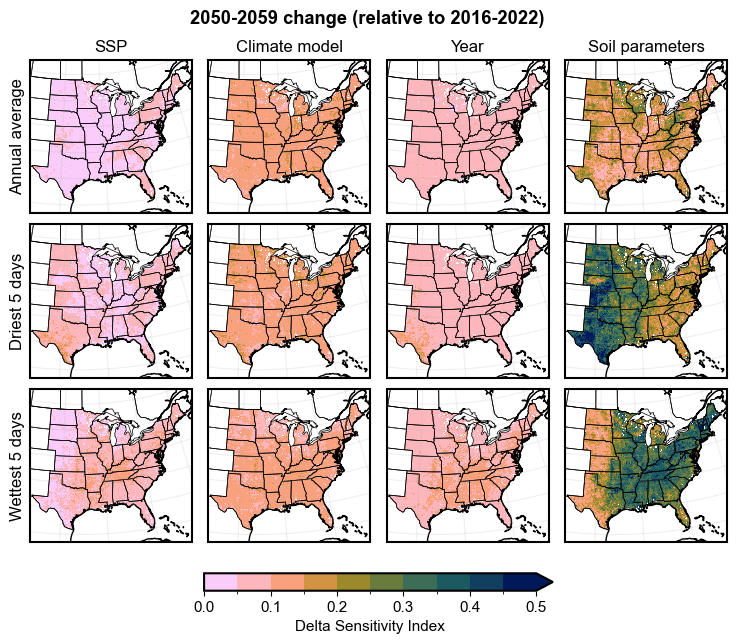

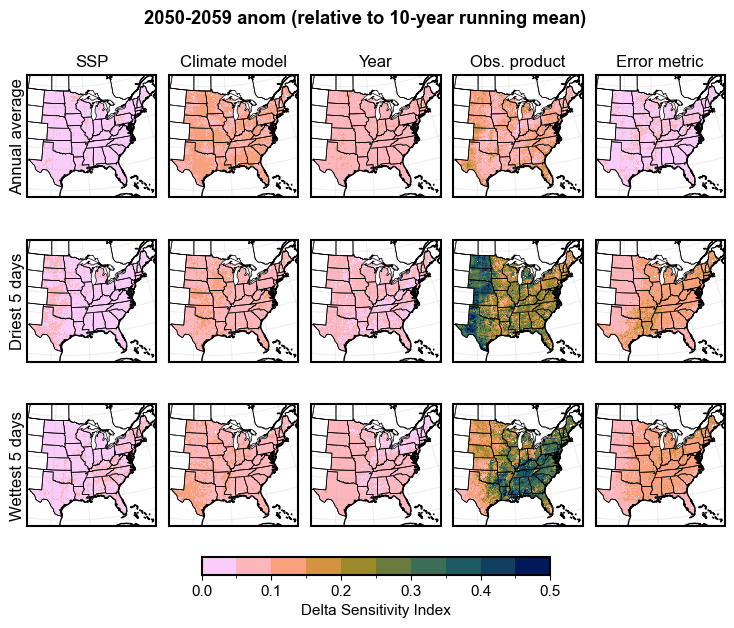

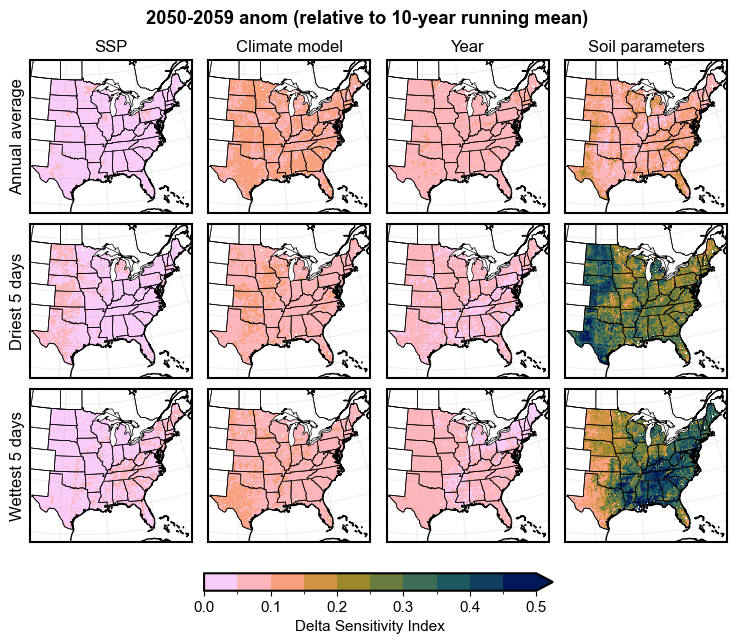

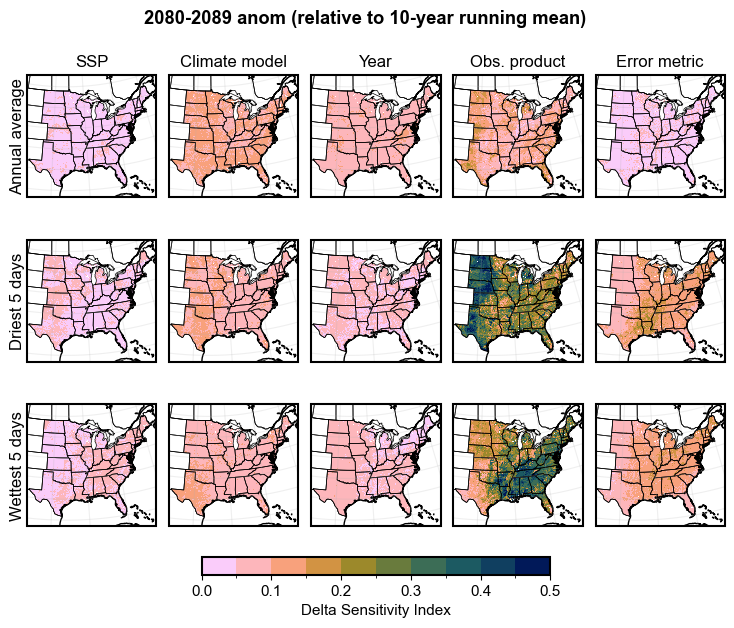

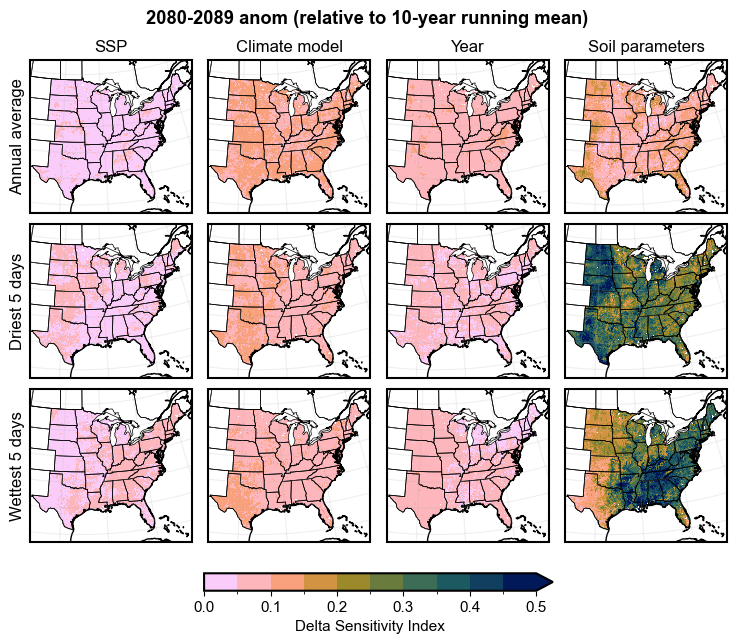

In [12]:
# Loop through all
save_folder = "si"

for metric_type in ['change', 'anom']:
    for year in ["2050-2059", "2080-2089"]:
        for soil_sa in ['all', 'soil_grouped']:
            try:
                make_sa_map_plot(metric_type, year, soil_sa, save_folder)
            except:
                print(metric_type, year, soil_sa)

## Single gridpoint

In [9]:
#####################
# PDF and SA
######################

In [8]:
# Info
soil_metric = soil_metrics[3]
soil_label = soil_labels[soil_metric].replace('\n', '')
ssps = ['ssp245', 'ssp370']
time_slice = time_slices[1]

In [9]:
%%time
ds_all = read_all(subset_name, soil_metric, ssps)

CPU times: user 35.8 s, sys: 12.1 s, total: 47.9 s
Wall time: 1min 22s


In [13]:
ds_all

<xarray.Dataset> Size: 90GB
Dimensions:        (projection_id: 45, obs_name: 4, loss_metric: 13, time: 78,
                    lat: 194, lon: 317)
Coordinates: (12/13)
  * lon            (lon) float64 3kB -106.6 -106.4 -106.3 ... -67.19 -67.06
  * lat            (lat) float64 2kB 25.19 25.31 25.44 ... 49.06 49.19 49.31
  * time           (time) int64 624B 2023 2024 2025 2026 ... 2097 2098 2099 2100
    sim_id         (obs_name, loss_metric) <U26 5kB 'kge_00r_noval' ... 'ubrm...
    model          (projection_id) <U15 3kB 'ACCESS-CM2' ... 'TaiESM1'
    member         (projection_id) <U9 2kB 'r1i1p1f1' 'r1i1p1f1' ... 'r1i1p1f1'
    ...             ...
  * obs_name       (obs_name) <U6 96B 'SMAP' 'VIC' 'NOAH' 'MOSAIC'
  * loss_metric    (loss_metric) <U13 676B 'kge' 'mae' ... 'ubmse' 'ubrmse'
    param_id       (obs_name, loss_metric) <U6 1kB '00r' '00r' ... '00r' '00r'
    val_id         <U5 20B 'noval'
  * projection_id  (projection_id) <U37 7kB 'LOCA2/ACCESS-CM2_r1i1p1f1_ssp245...
    soil_id        (obs_name, loss_metric) <U33 7kB 'SMAP_kge_00r_noval' ... ...
Data variables:
    mean-change    (projection_id, obs_name, loss_metric, time, lat, lon) float64 90GB dask.array<chunksize=(1, 1, 1, 78, 194, 317), meta=np.ndarray>

In [19]:
ds_all.drop_vars(['sim_id', 'model', 'member', 'ssp', 'param_id', 'val_id', 'soil_id'])

<xarray.Dataset> Size: 90GB
Dimensions:        (projection_id: 45, obs_name: 4, loss_metric: 13, time: 78,
                    lat: 194, lon: 317)
Coordinates:
  * lon            (lon) float64 3kB -106.6 -106.4 -106.3 ... -67.19 -67.06
  * lat            (lat) float64 2kB 25.19 25.31 25.44 ... 49.06 49.19 49.31
  * time           (time) int64 624B 2023 2024 2025 2026 ... 2097 2098 2099 2100
  * obs_name       (obs_name) <U6 96B 'SMAP' 'VIC' 'NOAH' 'MOSAIC'
  * loss_metric    (loss_metric) <U13 676B 'kge' 'mae' ... 'ubmse' 'ubrmse'
  * projection_id  (projection_id) <U37 7kB 'LOCA2/ACCESS-CM2_r1i1p1f1_ssp245...
Data variables:
    mean-change    (projection_id, obs_name, loss_metric, time, lat, lon) float64 90GB dask.array<chunksize=(1, 1, 1, 78, 194, 317), meta=np.ndarray>

In [ ]:
dsq = (ds_all.drop_vars(['sim_id', 'model', 'member', 'ssp', 'param_id', 'val_id', 'soil_id'])
       .sel(time=slice("2050","2059"))
       .chunk(dict(projection_id=-1, obs_name=-1, loss_metric=-1, lat=20, lon=20))
       .quantile(0.975, dim=['projection_id', 'obs_name', 'loss_metric'])
      ).compute()

In [20]:
%%time
# Get single point: McLean County
lat1, lon1 = 40.61752192312278, -88.68366477345201

# Get locs
df_loc1 = ds_all.sel(lat=lat1, lon=lon1, method="nearest")
df_loc1 = df_loc1[soil_metric].to_dataframe().reset_index()

CPU times: user 16.9 s, sys: 783 ms, total: 17.7 s
Wall time: 37.4 s


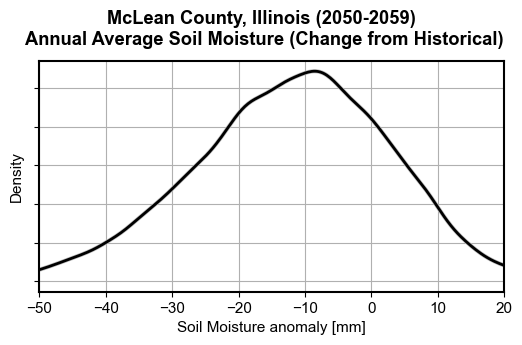

In [25]:
# Single PDF plot
df_plot = df_loc1.query(f'time >= {time_slice[0]} and time <= {time_slice[1]}')

fig, ax = plt.subplots(figsize=(6,3), sharex=False, sharey=True)

# Set xlims
xlims = [-50,20]

# Obs name
df_plot[soil_metric].plot.kde(ax=ax, color='silver', lw=3)

# Add unconditional PDF
df_plot[soil_metric].plot.kde(ax=ax, color='black', lw=2, label="All")
ax.grid()
ax.set_yticklabels([])
ax.set_xlim(xlims)
ax.set_xlabel('Soil Moisture anomaly [mm]')

fig.suptitle(f"McLean County, Illinois ({time_slice[0]}-{time_slice[1]}) \n{soil_label}", fontweight='bold', y=1.05)

plt.savefig(f'../figs/si/il_pdf_{soil_metric}.pdf', bbox_inches='tight')

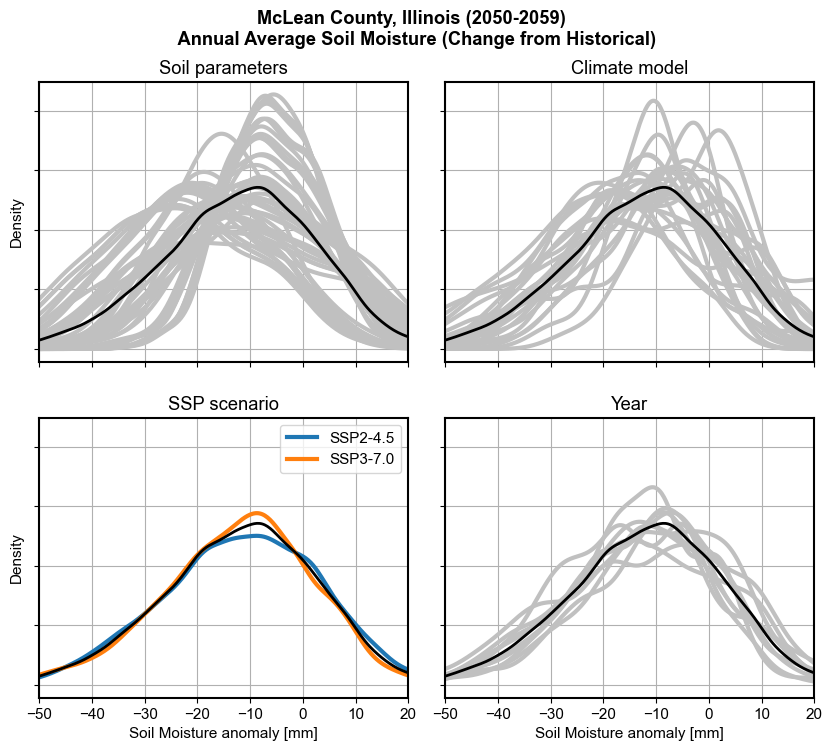

In [26]:
# PDF plot all
df_plot = df_loc1.query(f'time >= {time_slice[0]} and time <= {time_slice[1]}')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8), sharex=False, sharey=True, gridspec_kw={'wspace':0.1})
axs=axs.flatten()

# Set xlims
xlims = [-50,20]

# Loss metric
ax=axs[0]
ax.set_title('Soil parameters')
df_plot.groupby('soil_id')[soil_metric].plot.kde(ax=ax, lw=3, color='silver')
ax.set_xlim(xlims)
ax.set_xticklabels([])
# custom_lines = [Line2D([0], [0], color='black', lw=2)]
# ax.legend(custom_lines, ['All'])

# GCM
ax=axs[1]
ax.set_title('Climate model')
df_plot.groupby('model')[soil_metric].plot.kde(ax=ax, lw=3, color='silver')
ax.set_xlim(xlims)
ax.set_xticklabels([])

# SSP
ax=axs[2]
ax.set_title('SSP scenario')
for ssp, group in df_plot.groupby('ssp'):
    ssp_name = f"SSP{ssp[3]}-{ssp[4]}.{ssp[5]}"
    group[soil_metric].plot.kde(ax=ax, lw=3, label=ssp_name)
ax.legend()
ax.set_xlim(xlims)
ax.set_xlabel('Soil Moisture anomaly [mm]')

# Time
ax=axs[3]
ax.set_title('Year')
df_plot.groupby('time')[soil_metric].plot.kde(ax=ax, lw=3, color='silver')
ax.set_xlim(xlims)
ax.set_xlabel('Soil Moisture anomaly [mm]')

# Add unconditional PDF
for ax in axs:
    df_plot[soil_metric].plot.kde(ax=ax, color='black', lw=2)
    ax.grid()
    ax.set_yticklabels([])

fig.suptitle(f"McLean County, Illinois ({time_slice[0]}-{time_slice[1]}) \n {soil_label}", fontweight='bold', y=0.97)

plt.savefig(f'../figs/si/il_pdf_all_{soil_metric}.pdf', bbox_inches='tight')

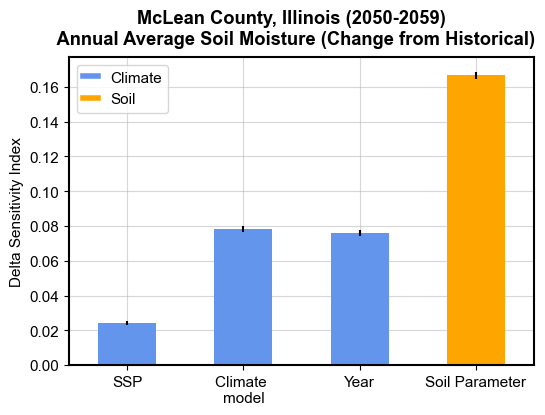

In [23]:
# SA plot
sa_factors_all = ['ssp', 'model', 'time', 'obs_name', 'loss_metric']
sa_factors_grouped = ['ssp', 'model', 'time', 'soil_id']
soil_sa = "soil_grouped"
sa_factors = sa_factors_grouped if soil_sa == "soil_grouped" else sa_factors_all

Si = get_delta_single(df_loc1, soil_metric, sa_factors)

# Plot
fig, ax = plt.subplots(1,1, figsize=(6,4))
fig.suptitle(f"McLean County, Illinois ({time_slice[0]}-{time_slice[1]}) \n {soil_label}", fontweight='bold', y=1.)

plot_sa_single(Si, sa_factors, climate_color, soil_color, index_labels, True, True, ax)

plt.savefig(f'../figs/si/il_sa_{soil_sa}_{soil_metric}.pdf', bbox_inches='tight')

# Timeseries plots

In [7]:
coords = {'mclean': (40.61752192312278, -88.68366477345201), 
          'bigbend': (29.22124625856724, -103.22586554830667),
          'smoky': (35.61832908163286, -83.66546369858804)}

In [14]:
def plot_timeseries(coords, ax, legend):
    lat, lon = coords
    # Get location coordinates
    ds_grid = xr.open_dataset(f"{project_data_path}/WBM/calibration/CONUS/SMAP/SMAP_validation.nc")
    lons = ds_grid.lon
    lats = ds_grid.lat

    # Get indices
    ix = (np.abs(lons - lon)).argmin().values
    iy = (np.abs(lats - lat)).argmin().values

    # x-axis
    time = xr.cftime_range(start='2016-01-01', end='2022-12-31', calendar='365_day')

    # Plot
    for obs_name in ["SMAP", "VIC", "MOSAIC", "NOAH"]:
        ds_tmp = np.load(f"{project_data_path}/WBM/calibration/CONUS/{obs_name}/{obs_name}_validation.npy")
        # ax.plot(time, ds_tmp[ix, iy, :], label=obs_name, color=obs_colors[obs_name])
        ax.plot(time, ds_tmp[ix, iy, :] - np.mean(ds_tmp[ix, iy, :]), label=obs_name, color=obs_colors[obs_name])
    
    # Tidy
    if legend:
        ax.legend()
        
    ax.grid()
    ax.set_ylabel('Soil Moisture [mm]')

In [15]:
experiment = "bigbend"
ensemble_name = 'LOCA2'
file_names = os.listdir(f"{project_data_path}/projections/{subset_name}/out_nc/{ensemble_name}/{experiment}")

<timed exec>:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


CPU times: user 1min 32s, sys: 3.09 s, total: 1min 35s
Wall time: 1min 47s


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-09-jax/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


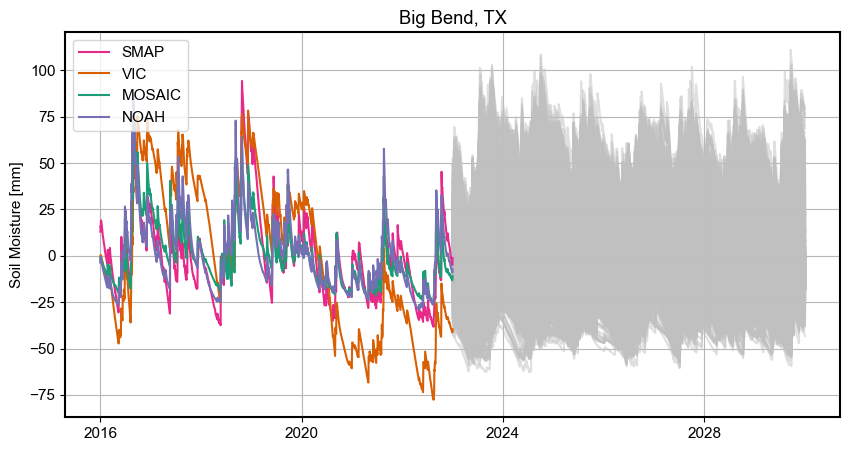

In [16]:
%%time
fig, ax = plt.subplots(figsize=(10,5))

# Plot models
for file_name in file_names:
    ds = xr.open_dataset(f"{project_data_path}/projections/{subset_name}/out_nc/{ensemble_name}/{experiment}/{file_name}")
    (ds['soilMoist'] - ds['soilMoist'].mean(dim='time')).plot(ax=ax, color='silver', alpha=0.5)
    # ds['soilMoist'].plot(ax=ax, color='silver', alpha=0.5)

# Plot obs
plot_timeseries(coords[experiment], ax, True)

ax.set_title('Big Bend, TX')
ax.grid(alpha=0.9)
ax.set_xlabel('')
plt.savefig(f'../figs/{experiment}_ts_daily_proj.png', dpi=600, bbox_inches='tight')

In [ ]:
### Timeseries plot
soil_metric_name = 'Soil Moisture [mm]'

fig, ax = plt.subplots(1,1, figsize=(10,5), sharex=True, sharey=True, layout='constrained')
# axs = axs.flatten()

fig.suptitle(f"McLean County, Illinois; {soil_label}", fontweight='bold')

df_plot = df_loc1[(df_loc1['time'] >= 2030) & (df_loc1['time'] <= 2095)]

times = df_plot['time'].unique()

ax.fill_between(times,
                df_plot.groupby('time')[soil_metric].quantile(0.9),
                df_plot.groupby('time')[soil_metric].quantile(0.1),
                alpha=0.5, color='C0')

ax.fill_between(times,
                df_plot.groupby('time')[soil_metric].quantile(0.99),
                df_plot.groupby('time')[soil_metric].quantile(0.01),
                alpha=0.5, color='C0')

ax.fill_between(times,
                df_plot.groupby('time')[soil_metric].max(),
                df_plot.groupby('time')[soil_metric].min(),
                alpha=0.5, color='C0')

ax.plot(times, df_plot.groupby('time')[soil_metric].mean(),
        color='white')

ax.set_ylabel(soil_metric_name)
ax.grid(alpha=0.8)

# plt.savefig(f'../figs/il_ts_{soil_metric}.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# ### Timeseries plot
# soil_metric_name = 'Soil Moisture [mm]'

# fig, ax = plt.subplots(1,1, figsize=(10,5), sharex=True, sharey=True, layout='constrained')
# # axs = axs.flatten()

# fig.suptitle(f"McLean County, Illinois; {soil_label}", fontweight='bold')

# for idx, obs_name in enumerate(obs_names):
#     # ax=axs[idx]
#     # Subset time and obs
#     df_sel = df_loc1[df_loc1['obs_name'] == obs_name]
#     df_sel = df_sel[(df_sel['time'] >= 2030) & (df_sel['time'] <= 2095)]
    
#     # Individual projections
#     for projection_id in df_sel['projection_id'].unique():
#         for soil_id in df_sel['soil_id'].unique():
#             df_plot = df_sel[(df_sel['projection_id'] == projection_id) & (df_sel['soil_id'] == soil_id)]
#             df_plot = df_plot.sort_values('time')
#             ax.plot(df_plot['time'], df_plot[soil_metric], color='silver', alpha=0.5)
    
#     # # Individual projections
#     # for iss, ssp in enumerate(['ssp245','ssp370']):
#     #     # Model mean
#     #     for model in df_sel['model'].unique():
#     #         df_plot = df_sel[(df_sel['model'] == model) & (df_sel['ssp'] == ssp)].groupby('time')[soil_metric].mean().reset_index()
#     #         df_plot = df_plot.sort_values('time')
#     #         ax.plot(df_plot['time'], df_plot[soil_metric], color=f'C{iss}', alpha=0.9)

#     # Tidy
#     # ax.set_title(obs_name)
#     ax.set_ylabel(soil_metric_name)
#     ax.grid(alpha=0.8)

# # axs[1].set_ylabel('')
# # custom_lines = [Line2D([0], [0], color='C0', lw=2),
# #                Line2D([0], [0], color='C1', lw=2)]
# # axs[0].legend(custom_lines, ['SSP2-4.5', 'SSP3-7.0 (climate model means)'],
# #               ncol=2, loc='lower left')

# # axs[3].set_ylabel('')

# # custom_lines = [Line2D([0], [0], color='silver', lw=2)]
# # axs[1].legend(custom_lines, ['All'], loc='lower left')

# plt.savefig(f'../figs/il_ts_{soil_metric}.png', dpi=600, bbox_inches='tight')